In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from pathlib import Path
from glob import glob
import os
from time import time

In [3]:
class Denoiser():
    """ Works on PIL <Image> objects.
    Denoiser.denoise() returns a denoised image, based on the model and
    input parameters.
    
    params
    ======
    
    image: an open PIL Image object
    model: a keras trained model object
    
    tile_size: <int> lenght, in pixel, of the square being denoised
        by the model. Higher values use higher amounts of RAM.
    
    """
    
    def __init__(self, image, model, tile_size=256, debug=False, verbose=True):
        self.image = image
        self.model = model
        self.tile_size = tile_size
        self.debug = debug
        self.verbose = verbose
        

    def _deb(self, *args, **kwargs):
        if self.debug:
            print(*args,**kwargs)

            
    def _say(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)

    # from Dataset class
    def _crop_in_tiles(self, image, tile_size=56, shift=0, asarray=True):

        """
        This generator function crops an image in several tiles
        tile_size × tile_size squares, yielding a tile
        every iteration.

        If the input image is not a perfect multiple of
        a(tile_size) × b(tile_size), non-square tiles are NOT
        YIELDED.

        params
        ======

        image: a Pillow open image
        tile_size: <int> pixels; size of the tile side
        shift: <int>: the offset from 0,0 in pixels
        
        yields
        ======
        
        A tile_size × tile_size np.array taken form the input image,
        but converted to float32 type and with values normalized from
        0 to 1
        """

        assert isinstance(tile_size, int)
        assert isinstance(shift, int)
        
        self._deb(f"debug: {tile_size} tile_size in _crop_in_tiles")

        width, height = image.size

        #calculate coordinates of every tile
        for x in range (0 + shift, width, tile_size):
            if width - x < tile_size:
                continue

            for y in range (0 + shift, height, tile_size):
                if height - y < tile_size:
                    continue

                # tile coord ===
                tile_coord = (
                    x, y, # upper left coords
                    x + tile_size, y + tile_size # lower right coords
                )

                tile = image.crop(tile_coord)

                if not asarray:
                    yield tile #yielding tile as image
                else:
                    yield np.array(tile).astype("float32") / 255
        
        
    def _predict_tiles_from_image(self, image, model, tile_size=56):
        """ This gives back the denoised <tiles>, according to the loaded <model>
        The model operates on multiple tiles at once. All tiles are shaped into a form
        that the model was trained for, then all put into a np.array container.
        This is the way the models expects the tiles for the prediction.

        NOTE: This function relies on crop_in_tiles() function.

        params
        ======

        image: a pillow Image object
        model: a keras trained model
        
        tile_size: <int> pixels. The model will operate and predict on a square with
            <tile_size> side. Higher values allocate higher amounts of RAM.
            
        returns
        ======
        
        A np.array containing all denoised (predicted) tiles
        """
        
        # all tiles need to be put into a list and reshaped to a form
        # the model is confortable with (x,x) to (x,x,1)
        
        self._deb(f"debug: {tile_size} tile_size in _predict_tiles_from_image")
        
        to_predict = [
            x.reshape(tile_size, tile_size, 1) for x in self._crop_in_tiles(image, tile_size)
        ]

        # the model expects an array of tiles, not a list of tiles
        to_predict = np.array(to_predict)

        return model.predict(to_predict)

    
    def _image_rebuilder(self, image, model, tile_size=56):
        """ Takes as input a monochromatic (single-channel) image,
        returns a denoised monochromatic image.
        
        params
        ======
        
        image: a PIL monochromatic image. ONLY ONE channel is supported
        model: a trained keras model to denoise the input image
        
        tile_size: <int> pixels of a square side to process at once.
            This is not related to the tile_size the model has been built
            with, but dictates how big is the square the model is fed with
            for denoising. The bigger this parameter, the more RAM is needed
            to perform the denoising.
            This cannot be higher than the image phisical size.
            
        returns
        =======
        A monochromatic, denoised PIL.Image object
        
        """

        # I was initially wondering to manage the channel splitting here,
        # but as the model is currently working on monochromatic images,
        # and will eventually manage the three channels with three different
        # models (again, with one channel per image), this stub of implementation
        # is not necessary anymore.
        # TODO: clear the clutter
        channels = [image]

        width, height = channels[0].size #all three channels have the same size
        self._say(f"width: {width}; height: {height}")

        # TODO
        # for now, we support only exact multiples of tile_size
        tile_width = int(width / tile_size)
        tile_height = int(height / tile_size)

        self._say(f"Image multiple of {tile_width}×{tile_height} integer tiles.")

        for i, channel in enumerate(channels):
            
            # next line useless if we just process one channel
            #self._say(f"Processing channel {i + 1} of {len(channels)}")
            self._deb(f"debug: {tile_size} tile_size in _image_rebuilder")
            
            pred_tiles = [self._predict_tiles_from_image(channel, model, tile_size=tile_size)]

            self._deb(f"Predicted tiles length: {len(pred_tiles[0])}")

            # now we need to rebuild a numpy array based on the tile_width*tile_height original geometry        
            gen = (x for x in pred_tiles[0])

            # the final assembly is very fast ===
            returnimage = []

            #for i in range(tile_height):
            #    row_tiles = next(gen)
            #    for j in range(tile_width - 1):
            #        next_tile = next(gen)
            #        row_tiles = np.concatenate((row_tiles, next_tile), axis=1)
            #    returnimage.append(row_tiles)
            #
            #returnimage = np.array(returnimage)
            #returnimage = np.vstack(returnimage)

            for i in range(tile_width):
                row_tiles = next(gen)
                for j in range(tile_height - 1):
                    next_tile = next(gen)
                    row_tiles = np.concatenate((row_tiles, next_tile), axis=0)
                returnimage.append(row_tiles)

            returnimage = np.array(returnimage)
            returnimage = np.hstack(returnimage)

            # from array (0-1) to Image (0-255)
            returnimage = np.uint8(returnimage * 255)
            
            # discarding the last dimension
            return Image.fromarray(returnimage[:,:,0])   

        
    def denoise(self, show=True):
        
        self._say("Denoising red channel..")
        denoised_r = self._image_rebuilder(
            self.image.getchannel("R"), self.model, self.tile_size
        )
        
        self._say("Denoising green channel..")
        denoised_g = self._image_rebuilder(
            self.image.getchannel("G"), self.model, self.tile_size
        )
        
        self._say("Denoising blue channel..")
        denoised_b = self._image_rebuilder(
            self.image.getchannel("B"), self.model, self.tile_size
        )
        
        rgb = Image.merge("RGB",(denoised_r, denoised_g, denoised_b))
        
        
        self.denoised_ = rgb
        del denoised_r, denoised_g, denoised_b
        self._say("Denoised image in 'denoised_' attribute.")
        
        if show:
            return rgb

# Compact code for denoising without tiling artefacst

In [4]:
# Preparing the transparency masks

# vertical stripes (operazione 1)
def make_vertical_stripes(n_tiles, as_image=True, final=False):
    arrays = []
    
    arrays.append(np.ones((height, t - halfdelta), dtype=np.uint8)*255)
    arrays.append(np.zeros((height, delta), dtype=np.uint8))

    for _ in range(n_tiles - 2):
        arrays.append(np.ones((height, t - delta), dtype=np.uint8)*255)
        arrays.append(np.zeros((height, delta), dtype=np.uint8))        

    arrays.append(np.ones((height, t - delta), dtype=np.uint8)*255)
    
    if final:
        arrays.append(np.ones((height, halfdelta), dtype=np.uint8)*255) # modified
    else:
        arrays.append(np.zeros((height, halfdelta), dtype=np.uint8)) # modified

    vertical_stripes = np.concatenate(arrays, axis=1)
    
    if not as_image:
        return vertical_stripes
    else:
        return Image.fromarray(vertical_stripes)


# horizontal stripes (operazione 4)
def make_horizontal_stripes(n_tiles, as_image=True, final=False):
    arrays = []
    
    arrays.append(np.ones((t - halfdelta, width), dtype=np.uint8)*255)
    arrays.append(np.zeros((delta, width), dtype=np.uint8))

    for _ in range(n_tiles - 2):
        arrays.append(np.ones((t - delta, width), dtype=np.uint8)*255)
        arrays.append(np.zeros((delta, width), dtype=np.uint8))        

    arrays.append(np.ones((t - delta, width), dtype=np.uint8)*255)
    
    if final:
        arrays.append(np.ones((halfdelta, width), dtype=np.uint8)*255) # modified
    else:
        arrays.append(np.zeros((halfdelta, width), dtype=np.uint8))

    horizontal_stripes = np.concatenate(arrays, axis=0)

    if not as_image:
        return horizontal_stripes
    else:
        return Image.fromarray(horizontal_stripes)

# ---
# crops, black bars

def make_black_img(hsize, vsize):
    channels = [np.zeros((vsize, hsize), dtype=np.uint8) for _ in range(3)]
    channels = [Image.fromarray(x) for x in channels]
    
    return Image.merge("RGB", channels)

# ---

def make_left_crop(image, amount, as_image=True):
    # amount is usually half_t
    
    cropshift = image.crop((amount, 0, width, image.height)) # (left, upper, right, lower)

    if not as_image:
        return np.array(cropshift)
    else:
        return cropshift

    
def make_right_crop(image, amount, as_image=True):
    # amount is usually half_t
    
    cropshift = image.crop((0, 0, width - amount, image.height)) # (left, upper, right, lower)

    if not as_image:
        return np.array(cropshift)
    else:
        return cropshift

    
def apply_left_bar(image, amount, as_image=True):
    # amount is usually half_t
    
    leftbar = make_black_img(amount, image.height)
    shift = np.concatenate((np.array(leftbar), np.array(image)), axis=1)

    if not as_image:
        return shift
    else:
        return Image.fromarray(shift)

    
def apply_right_bar(image, amount, as_image=True):
    # amount is usually half_t
    
    rightbar = make_black_img(amount, image.height)
    
    try:
        shift = np.concatenate((np.array(image), np.array(rightbar)), axis=1)
    except:
        print("Something went wrong.")
        print(f"Image array shape: {np.array(image).shape}; bar: {np.array(rightbar).shape}")
        print("Are you trying to process a base image with alpha channel?")
        raise

    if not as_image:
        return shift
    else:
        return Image.fromarray(shift)


# ---

    
def make_top_crop(image, amount, as_image=True):
    # amount is usually half_t
    
    cropshift = image.crop((0, amount, image.width, image.height)) # (left, upper, right, lower)

    if not as_image:
        return np.array(cropshift)
    else:
        return cropshift

    
def make_bottom_crop(image, amount, as_image=True):
    # amount is usually half_t
    
    cropshift = image.crop((0, 0, image.width, image.height - amount)) # (left, upper, right, lower)

    if not as_image:
        return np.array(cropshift)
    else:
        return cropshift

    
def apply_top_bar(image, amount, as_image=True):
    # amount is usually half_t
    
    topbar = make_black_img(image.width, amount)
    shift = np.concatenate((np.array(topbar), np.array(image)), axis=0)

    if not as_image:
        return shift
    else:
        return Image.fromarray(shift)

    
def apply_bottom_bar(image, amount, as_image=True):
    # amount is usually half_t
    
    bottombar = make_black_img(image.width, amount)
    shift = np.concatenate((np.array(image), np.array(bottombar)), axis=0)

    if not as_image:
        return shift
    else:
        return Image.fromarray(shift)

# ---
def apply_mask(image, mask):
    
    assert image.size == mask.size
    r, g, b = (image.getchannel(x) for x in "RGB")
    
    rgba = Image.merge("RGBA",(r, g, b, mask))
    
    return rgba

Image properties: 256×192 pixels
Tile size: 64; half tile size: 32; 4×3 total tiles
Intersection Δ: 10; half Δ: 5
Pass 1/4
Denoising red channel..
width: 256; height: 192
Image multiple of 4×3 integer tiles.
Denoising green channel..
width: 256; height: 192
Image multiple of 4×3 integer tiles.
Denoising blue channel..
width: 256; height: 192
Image multiple of 4×3 integer tiles.
Denoised image in 'denoised_' attribute.
Complete. 0.7 seconds elapsed.
Pass 2/4
Denoising red channel..
width: 256; height: 192
Image multiple of 4×3 integer tiles.
Denoising green channel..
width: 256; height: 192
Image multiple of 4×3 integer tiles.
Denoising blue channel..
width: 256; height: 192
Image multiple of 4×3 integer tiles.
Denoised image in 'denoised_' attribute.
Complete. 0.7 seconds elapsed.
Pass 3/4
Denoising red channel..
width: 224; height: 128
Image multiple of 3×2 integer tiles.
Denoising green channel..
width: 224; height: 128
Image multiple of 3×2 integer tiles.
Denoising blue channel..
wi

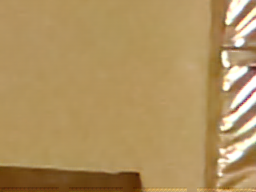

In [11]:
# INPUT
#base = Image.open("cane 512×384 px.png").convert("RGB")
base = Image.open("reallife 256x192.jpg").convert("RGB")
model = keras.models.load_model("model2_ds2_27x512_strides2_13x256_strides2_RMSProp_mse")


width, height = base.size

t = 64                            # tile size (tile is t×t size)
half_t = t // 2                   # half the tile size
n_horizontal_tiles = width // t   # choose reasonably so that no pixel is lost
n_vertical_tiles = height // t    # choose reasonably so that no pixel is lost
delta = 10                        # the number of pixels to make transparent at t intersections
halfdelta = delta // 2            # the number of delta pixels in a tile

print(f"Image properties: {width}×{height} pixels")
print(f"Tile size: {t}; half tile size: {half_t}; {n_horizontal_tiles}×{n_vertical_tiles} total tiles")
print(f"Intersection Δ: {delta}; half Δ: {halfdelta}")

# transparency masks
vertical_mask = make_vertical_stripes(n_horizontal_tiles) # counter-intuitive
horizontal_mask  = make_horizontal_stripes(n_vertical_tiles) # counter-intuitive

# horizontal processing
t0 = time()
print("Pass 1/4")

lc = make_left_crop(base, half_t)
lc_rightbar = apply_right_bar(lc, half_t)
rightshift = Denoiser(lc_rightbar, model, tile_size=64)
rightshift.denoise(show=False)
rc = make_right_crop(rightshift.denoised_, half_t)
rightshift = apply_left_bar(rc, half_t)

t0_final = time() - t0
print(f"Complete. {round(t0_final, 1)} seconds elapsed.")

# vertical processing
t1 = time()
print("Pass 2/4")

tc = make_top_crop(base, half_t)
lc_bottombar = apply_bottom_bar(tc, half_t)
downshift = Denoiser(lc_bottombar, model, tile_size=64)
downshift.denoise(show=False)
bc = make_bottom_crop(downshift.denoised_, half_t)
downshift = apply_top_bar(bc, half_t)

t1_final = time() - t1
print(f"Complete. {round(t1_final, 1)} seconds elapsed.")

# diagonal processing
t2 = time()
print("Pass 3/4")
diag = make_right_crop(base, half_t)
diag = make_bottom_crop(diag, half_t)
diag = make_left_crop(diag, half_t)
diag = make_top_crop(diag, half_t)
diag_d = Denoiser(diag, model, tile_size=64)
diag_d.denoise(show=False)
diagshift = diag_d.denoised_
diagshift = apply_right_bar(diagshift, half_t)
diagshift = apply_bottom_bar(diagshift, half_t)
diagshift = apply_top_bar(diagshift, half_t)
diagshift = apply_left_bar(diagshift, half_t)

t2_final = time() -t2
print(f"Complete. {round(t2_final, 1)} seconds elapsed.")


# Denoising the base image
t3 = time()
print("Pass 4/4")
base_d = Denoiser(base, model, tile_size=64)
base_d.denoise(show=False)


t3_final = time() -t3
print(f"Complete. {round(t3_final, 1)} seconds elapsed.")


# RECONSTRUCTION STEPS
t4 = time()
print("Reconstructing the denoised image..")
# Operazione 1: rimozione delle intersezioni verticali da immagine base
step1 = apply_mask(base_d.denoised_, vertical_mask)
# Operazione 2: denoise dell'immagine spostata verso dx di 32 px (rappresentata in arancione):
step2 = rightshift
# Operazione 3: merge
step3 = Image.alpha_composite(step2.convert("RGBA"), step1)
# Operazione 4: rimozione delle intersezioni orizzontali da immagine base
step4 = apply_mask(base_d.denoised_, horizontal_mask)
# Operazione 5: denoise dell'immagine spostata verso il basso di 32 px (rappresentata in verde):
step5 = downshift.copy()
# Operazione 6: merge
step6 = Image.alpha_composite(step5.convert("RGBA"), step4)
# Operazione 7: denoise dell'immagine spostata verso dx e verso il basso di 32 px (rappresentata in rosso):
step7 = diagshift.copy()

final_vertical_mask = make_vertical_stripes(n_horizontal_tiles, final=True) # counter-intuitive
final_horizontal_mask  = make_horizontal_stripes(n_vertical_tiles, final=True) # counter-intuitive

# Operazione 8: rimozione delle intersezioni orizzontali dall'immagine da operazione 3:
step8 = apply_mask(step3, final_horizontal_mask)
# Operazione 9: rimozione delle intersezioni verticali dall'immagine da operazione 6:
step9 = apply_mask(step6, final_vertical_mask)
# Operazione 10: merge delle immagini da operazioni 7, 8 e 9:
step10 = Image.alpha_composite(step8, step9)
step10 = Image.alpha_composite(step7.convert("RGBA"), step10)

t4_final = time() -t4
print(f"Complete. {round(t4_final, 1)} seconds elapsed.")

tot_time = t0_final + t1_final + t2_final + t3_final + t4_final
print(f"Total processing time: {round(tot_time, 1)} seconds.")

step10

In [ ]:
# perfetto!

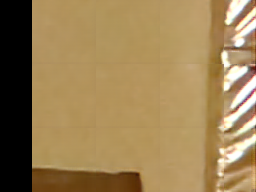

In [14]:
rightshift

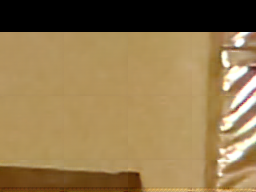

In [15]:
downshift

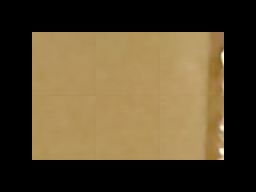

In [16]:
diagshift